# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных** 

Данные состоят из файлов, полученных из разных источников:
- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Цель проекта**
Построить модель, которая предсказывает температуру стали.

**План**
1. Провести исследовательский анализ данных
2. Объединение таблиц в один датасет
3. Исследование объединенного датасета
4. Обучение моделей
5. Тестирование лучшей модели
6. Общий вывод

## Исследовательский анализ данных (EDA)

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score

In [2]:
random_state = 310723

In [3]:
try:
    data_arc = pd.read_csv(r'C:\Users\kuzmi\Downloads\data_arc_new.csv')
except:
    data_arc = pd.read_csv(r'https://code.s3.yandex.net/datasets/data_arc_new.csv')
try:    
    data_bulk = pd.read_csv(r'C:\Users\kuzmi\Downloads\data_bulk_new.csv')
except:
    data_bulk = pd.read_csv(r'https://code.s3.yandex.net/datasets/data_bulk_new.csv')
try:    
    data_temp = pd.read_csv(r'C:\Users\kuzmi\Downloads\data_temp_new.csv')
except:
    data_temp = pd.read_csv(r'https://code.s3.yandex.net/datasets/data_temp_new.csv')
try: 
    data_gas = pd.read_csv(r'C:\Users\kuzmi\Downloads\data_gas_new.csv')
except:
    data_gas = pd.read_csv(r'https://code.s3.yandex.net/datasets/data_gas_new.csv')
try:
    data_bulk_time = pd.read_csv(r'C:\Users\kuzmi\Downloads\data_bulk_time_new.csv')
except:
    data_bulk_time = pd.read_csv(r'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
try:    
    data_wire = pd.read_csv(r'C:\Users\kuzmi\Downloads\data_wire_new.csv')
except:
    data_wire = pd.read_csv(r'https://code.s3.yandex.net/datasets/data_wire_new.csv')
try:
    data_wire_time = pd.read_csv(r'C:\Users\kuzmi\Downloads\data_wire_time_new.csv')
except:
    data_wire_time = pd.read_csv(r'https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [4]:
data_arc.info()
data_arc.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [5]:
data_arc[data_arc['Реактивная мощность'] < 0].count()

key                     1
Начало нагрева дугой    1
Конец нагрева дугой     1
Активная мощность       1
Реактивная мощность     1
dtype: int64

In [6]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


In [7]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

In [8]:
data_bulk.info()
data_bulk.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [9]:
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


In [10]:
data_bulk_time.info()
data_bulk_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [11]:
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [12]:
data_temp.info()
data_temp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [13]:
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


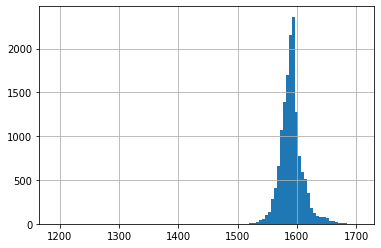

In [14]:
data_temp['Температура'].hist(bins=100);

In [15]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [16]:
data_temp[data_temp['Температура'] < 1500].count()

key             5
Время замера    5
Температура     5
dtype: int64

In [17]:
data_gas.info()
data_gas.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [18]:
data_wire.info()
data_wire.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_wire_time.info()
data_wire_time.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Вывод
- data_arc — данные об электродах. Есть отрицательное значение в реактивной мощности - весь ключ надо удалить. Данные по ключам необходимо объединить и агрегировать (суммированием).
- data_bulk — данные о подаче сыпучих материалов (объём), также
- data_bulk_time — данные о подаче сыпучих материалов (время), также
- data_wire — данные о проволочных материалах (объём), также
- data_wire_time — данные о проволочных материалах (время). Есть пропуски, заполним их нулями. Таблицы с временем подачи в итоговую таблицу не пойдут.
- data_gas — данные о продувке сплава газом, также
- data_temp — результаты измерения температуры. Есть температуры менее 1500 (5 наблюдений), эти ключи удаляем. В некоторых ковшах замеры делали несколько раз - данные надо агрегировать (получить среднее).


## Предобработка данных

In [20]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc['Продолжительность нагрева дугой, сек'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']) // pd.Timedelta('1s')

data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,"Продолжительность нагрева дугой, сек"
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148


In [21]:
data_arc = data_arc.groupby(by='key', as_index=False).sum()
data_arc.head(10)

,key,Активная мощность,Реактивная мощность,"Продолжительность нагрева дугой, сек"
0,1,3.036730,2.142821,1098
1,2,2.139408,1.453357,811
2,3,4.063641,2.937457,655
3,4,2.706489,2.056992,741
4,5,2.252950,1.687991,869
5,6,2.725274,1.881313,952
6,7,2.626877,1.960419,673
7,8,2.678958,2.096952,913
8,9,3.520820,2.527365,625
9,10,3.118778,2.154941,825


In [22]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9925176234568434

Корреляция очень высокая, поэтому объединим колонки в одну новую, а старые удалим

In [23]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2)

In [24]:
data_arc = data_arc[['key', 'Полная мощность', 'Продолжительность нагрева дугой, сек']]
data_arc.head(10)

,key,Полная мощность,"Продолжительность нагрева дугой, сек"
0,1,3.716640,1098
1,2,2.586371,811
2,3,5.014163,655
3,4,3.399456,741
4,5,2.815155,869
5,6,3.311564,952
6,7,3.277762,673
7,8,3.402062,913
8,9,4.334022,625
9,10,3.790850,825


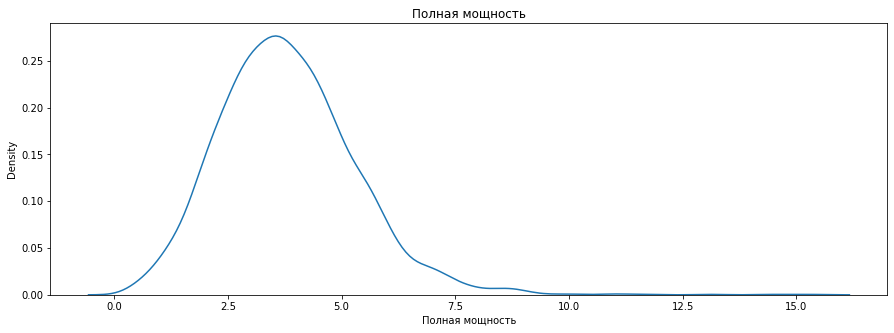

In [25]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(data_arc['Полная мощность'])
plt.title('Полная мощность');

In [26]:
data_bulk = data_bulk.fillna(0)

In [27]:
data_wire = data_wire.fillna(0)
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
data_temp = data_temp[data_temp['Температура'] >= 1500]

In [29]:
data_temp = data_temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Первый замер', 'Последний замер', 'Начальная температура', 'Конечная температура']
data_temp = data_temp[['key', 'Начальная температура', 'Конечная температура']]
data_temp.describe()

,key,Начальная температура,Конечная температура
count,3215.000000,3215.000000,3215.000000
mean,1621.907309,1589.195023,1594.049767
std,935.087320,25.015034,18.649454
min,1.000000,1519.000000,1529.000000
25%,815.500000,1572.000000,1585.000000
50%,1622.000000,1588.000000,1593.000000
75%,2430.500000,1606.000000,1600.000000
max,3241.000000,1684.000000,1700.000000


In [30]:
data_temp.head(10)

,key,Начальная температура,Конечная температура
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


In [31]:
data = (data_temp.merge(data_arc, how='inner', on = 'key').merge(data_wire, how='inner', on = 'key').merge(data_bulk, how='inner', on = 'key').merge(data_gas, how='inner', on='key'))

In [32]:
data.head(10)

,key,Начальная температура,Конечная температура,Полная мощность,"Продолжительность нагрева дугой, сек",Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,3.716640,1098,60.059998,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,2.586371,811,96.052315,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,5.014163,655,91.160157,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.399456,741,89.063515,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,2.815155,869,89.238236,9.114560,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
5,6,1543.0,1596.0,3.311564,952,99.109917,9.114560,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392
6,7,1586.0,1599.0,3.277762,673,98.061600,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267
7,8,1577.0,1598.0,3.402062,913,155.282394,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553
8,9,1587.0,1592.0,4.334022,625,113.393279,9.143681,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623
9,10,1574.0,1593.0,3.790850,825,81.244796,12.376000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,6.529891


In [33]:
data.describe()

,key,Начальная температура,Конечная температура,Полная мощность,"Продолжительность нагрева дугой, сек",Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
count,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,...,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.00000,3021.000000
mean,1623.002648,1587.413108,1592.022840,3.866589,801.617345,100.285615,17.561810,3.951476,0.266203,0.005009,...,2.513406,0.016220,0.479974,4.852036,4.500828,203.355180,1.079113,153.077789,118.70672,11.298667
std,931.882945,23.549655,15.076597,1.498793,331.674437,42.737477,33.310289,30.605064,4.336150,0.275309,...,32.496789,0.891499,6.262842,20.494765,23.086759,152.272881,14.363010,80.874207,83.40315,6.230988
min,1.000000,1519.000000,1529.000000,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.008399
25%,821.000000,1571.000000,1585.000000,2.828313,576.000000,71.370002,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.00000,7.281293
50%,1618.000000,1587.000000,1592.000000,3.749005,776.000000,100.151993,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.00000,10.015325
75%,2429.000000,1603.000000,1599.000000,4.764798,987.000000,125.798405,23.162880,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.00000,14.070262
max,3241.000000,1660.000000,1653.000000,15.272257,4189.000000,330.314424,282.780152,385.008668,113.231044,15.132000,...,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.00000,77.995040


In [34]:
data.tail()

,key,Начальная температура,Конечная температура,Полная мощность,"Продолжительность нагрева дугой, сек",Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
3016,3237,1569.0,1569.0,3.250143,909,38.088959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905
3017,3238,1584.0,1584.0,1.722728,546,56.128799,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669
3018,3239,1598.0,1598.0,6.003804,1216,143.357761,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518
3019,3240,1617.0,1617.0,4.079307,839,34.070400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0,11.863103
3020,3241,1586.0,1586.0,3.722015,659,63.117595,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,12.680959


In [35]:
data = data[data['key'] <= 2500]

In [36]:
data.tail()

,key,Начальная температура,Конечная температура,Полная мощность,"Продолжительность нагрева дугой, сек",Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
2325,2496,1554.0,1591.0,5.067396,940,114.179527,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,4.360104,569,94.086723,9.048000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,3.907887,750,118.110717,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657
2328,2499,1569.0,1603.0,2.167774,883,110.160958,50.005280,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,11.336151
2329,2500,1539.0,1539.0,2.762583,854,83.166710,61.224798,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,255.0,0.0,120.0,226.0,9.990718


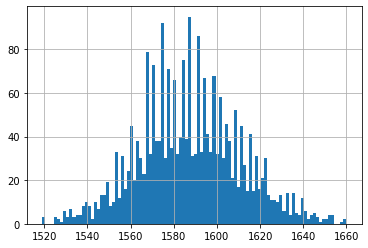

In [37]:
data['Начальная температура'].hist(bins=100);

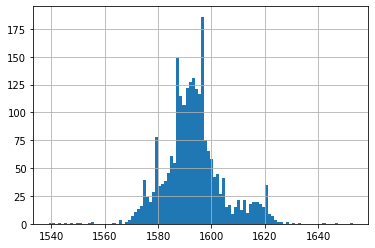

In [38]:
data['Конечная температура'].hist(bins=100);

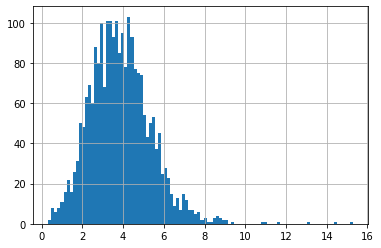

In [39]:
data['Полная мощность'].hist(bins=100);

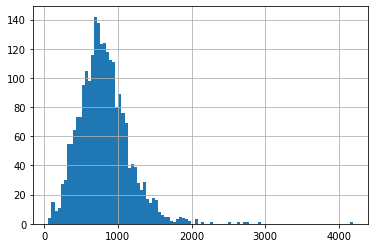

In [40]:
data['Продолжительность нагрева дугой, сек'].hist(bins=100);

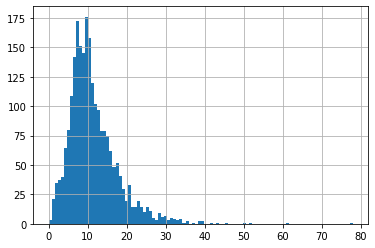

In [41]:
data['Газ 1'].hist(bins=100);

In [42]:
data = data.drop(['key'], axis=1)

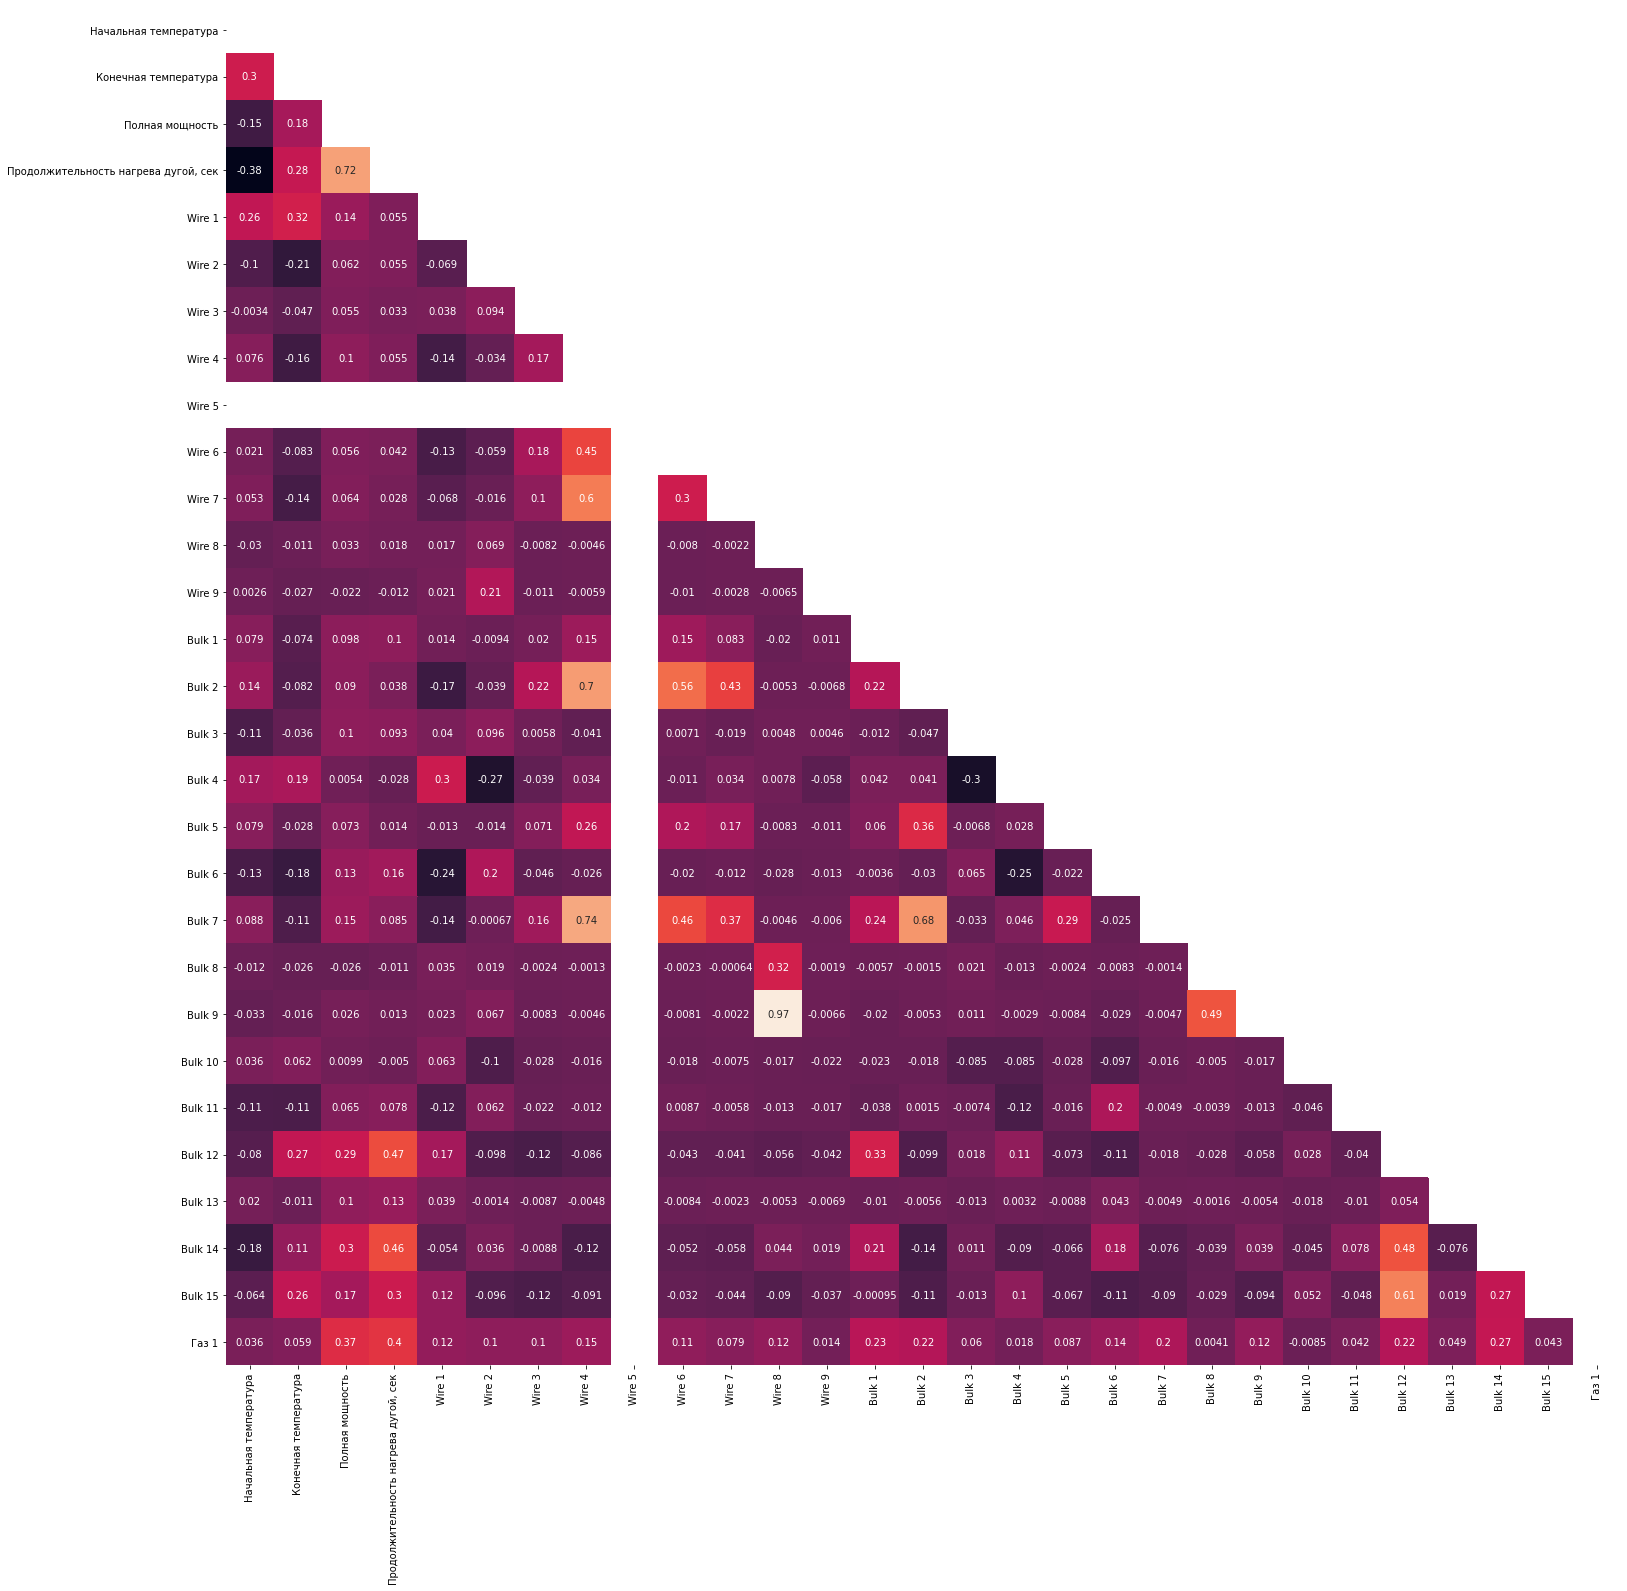

In [43]:
plt.figure(figsize=(25, 25))
matrix = np.triu(data.corr())
heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      mask=matrix,
                      cbar=False,
                      fmt='.2g')

По матрице корреляции видно, что столбец Wire_5 - пустой(его удалим), и высокая корреляция между Bulk_9 и Ware_8, один из них тоже удалим

In [44]:
data = data.drop(['Wire 5', 'Bulk 9'], axis=1)

In [45]:
data.rename(columns={'Начальная температура' : 'start_temp', 
                     'Конечная температура' : 'final_temp',
                     'Полная мощность' : 'full_power',
                     'Продолжительность нагрева дугой, сек' : 'heating_time_sec',
                     'Газ 1' : 'gas'}, inplace=True)

### Деление данных на выборки

In [46]:
train, test = train_test_split(data, test_size=0.25, random_state=310723)
train.shape

(1747, 27)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1747 entries, 1723 to 1992
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   start_temp        1747 non-null   float64
 1   final_temp        1747 non-null   float64
 2   full_power        1747 non-null   float64
 3   heating_time_sec  1747 non-null   int64  
 4   Wire 1            1747 non-null   float64
 5   Wire 2            1747 non-null   float64
 6   Wire 3            1747 non-null   float64
 7   Wire 4            1747 non-null   float64
 8   Wire 6            1747 non-null   float64
 9   Wire 7            1747 non-null   float64
 10  Wire 8            1747 non-null   float64
 11  Wire 9            1747 non-null   float64
 12  Bulk 1            1747 non-null   float64
 13  Bulk 2            1747 non-null   float64
 14  Bulk 3            1747 non-null   float64
 15  Bulk 4            1747 non-null   float64
 16  Bulk 5            1747 non-null   float

In [48]:
features_train_before_scaler = train.drop(['final_temp'], axis=1)
target_train = train['final_temp']

features_test = test.drop(['final_temp'], axis=1)
target_test = test['final_temp']

scaler = StandardScaler()
scaler.fit(features_train_before_scaler)
features_train = scaler.transform(features_train_before_scaler)
features_test = scaler.transform(features_test)
print(len(features_train))

1747


## Обучение моделей

### Линейная регрессия

In [49]:
model_lr = LinearRegression()
cv_model_lr = (cross_val_score(model_lr, 
                             features_train, 
                             target_train, 
                             cv=7, 
                             scoring='neg_mean_absolute_error').mean())
print('MAE на линейной регрессии', cv_model_lr.mean())

MAE на линейной регрессии -6.862568351100745


### CatBoost

In [50]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
print('# Train for mean_absolute_error')
print()
cv_MAE_CBR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)

# Train for mean_absolute_error

CPU times: user 16.7 s, sys: 700 ms, total: 17.4 s
Wall time: 23.2 s


In [51]:
print('Mean MAE from CV of CatBoostRegressor =', cv_MAE_CBR.mean())
print()
print("Best parameters set found on development set:")
print()
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(features_train, 
                                        target_train).get_all_params()
best_params_CBR

Mean MAE from CV of CatBoostRegressor = 6.325392825393903

Best parameters set found on development set:



{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 310723,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.0447160005569458,
 'score_function': 'Cosine',
 'task_t

### LGBM 

In [52]:
%%time
model_lgbm = LGBMRegressor()
lgbm_params = [{'num_leaves':[x for x in range(2,31, 10)],
                'max_depth':[x for x in range(1, 6, 2)],
                'min_samples_leaf':[x for x in range(1, 20, 6)],
                'learning_rate':[0.1],
                'n_estimators':[300],
                'random_state':[random_state]}]

gscv = GridSearchCV(model_lgbm, lgbm_params, scoring='neg_mean_absolute_error', cv=5)

gscv.fit(features_train, target_train)

best_params_LGBMR = gscv.best_params_
print('Параметры:', gscv.best_params_)
print()

MAE_lgbm = (max(gscv.cv_results_['mean_test_score'])*-1)
print('MAE для LGBMRegressor -', MAE_lgbm)
print()

[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[Light

Лучший результат у модели LGBMR, ее проверим на тестовой выборке

## Тестирование лучшей модели

In [53]:
%%time

lgbm = LGBMRegressor()
lgbm.fit(features_train, target_train)
test_predict = lgbm.predict(features_test)
test_MAE_lgbm = mean_absolute_error(test_predict, target_test)
print('MAE on test of LGBMRegressor =', test_MAE_lgbm)

MAE on test of LGBMRegressor = 6.3468525568785275
CPU times: user 21 s, sys: 237 ms, total: 21.2 s
Wall time: 21.4 s


### Сравнение с константной моделью

In [54]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
predict = model_dummy.predict(features_test)
mae_dummy = mean_absolute_error(target_test, predict)
mae_dummy

7.858406619139298

У константной модели МАЕ выше, следовательно, наша модель прошла проверку на адекватность.

### Исследование важности признаков

In [55]:
importances = lgbm.feature_importances_
feature_list = list(features_train_before_scaler.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,feature,importance
0,start_temp,466
1,heating_time_sec,381
2,Wire 1,322
3,gas,316
4,full_power,313
5,Bulk 14,291
6,Bulk 12,175
7,Bulk 6,135
8,Bulk 15,132
9,Bulk 3,114


Важными признаками являются начальная температура и время нагрева

## Итоговый вывод
Были проведены исследовательский анализ данных и их предобработка.
Обучены три модели: линейная регрессия, CatBoost и LGBMR. Наилучший результат в предсказании конечной температуры стали - у модели LGBMR с МАЕ = 6.3. Эту модель рекомендовано использовать.

## Отчет

**1. Сравнение решения и плана.**

В начальном плане были пропущены этапы предобработки данных, сравнения лучшей модели с константной и исследование важности признаков. В ходе решения эти этапы добавились.

**2. Описание трудностей проекта и как они были решены.**

Трудности были связаны с: 
- пониманием технологического процесса (решение - знакомство с процессом обработки стали),
- наличием большого числа пропусков в таблице с добавками (решение - замена пропусков нулями),
- обучение LGBMR тормозилось из-за неправильного подбора гиперпараметров (решение - с помощью тимлида были найдены нужные числа)

**3. Описание ключевых шагов решения.**

Ключевых шагов решения нет.

**4. Все признаки итоговой модели.**

Итоговой моделью стала LGBMR, все признаки в нее подавались после масштабирования(скалирования).
- Самый важный признак - начальная температура (start_temp), ее мы получили из таблицы data_temp_new.csv по ключу(key), определив первый по счету замер температуры в каждом ковше. Предварительно из таблицы были убраны значения температуры меньше 1500°С.
- Продолжительность нагрева дугой в сек (heating_time_sec). Дельта полученных из таблицы data_ark_new.csv данных о времени начала и конца нагрева дугой.
- Продувка стали газом (gas). Обрабатывать эти данные не было нужды.
- Полная мощность (full_power). Корень из суммы квадратов Активной и Реактивной мощностей. Последние две сильно коррелировали, поэтому решено было объединить их в один новый признак. Из столбца Реактивная мощность предварительно было удалено одно отрицательное значение.
- Данные о проволочных материалах(Wire) и сыпучих добавках(Bulk). Все пропуски были заменены нулями. Высокоскоррелированные признаки удалены.

**5. Полное описание итоговой модели.**

Итоговой моделью была выбрана LGBMR, которая показала МАЕ=6.3 на обучающей и тестовой выборках. Гиперпараметры модели: 'learning_rate': 0.1, 'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 300, 'num_leaves': 2, 'random_state': 310723. 